In [1]:
import yaml
import torch
import torch.nn as nn
import numpy as np
import tqdm
import os
import argparse
from torch.backends import cudnn

cudnn.benchmark = True

def delete_module(name):
    import sys
    del sys.modules[name]

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
config_file = './test_config.yaml'

def dict2namespace(config):
    namespace = argparse.Namespace()
    for key, value in config.items():
        if isinstance(value, dict):
            new_value = dict2namespace(value)
        else:
            new_value = value
        setattr(namespace, key, new_value)
    return namespace

with open(config_file, 'r') as f:
    config = yaml.load(f)
        
cfg = dict2namespace(config)
cfg

/pkgs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  


Namespace(data=Namespace(batch_size=1, cates=['airplane'], data_dir='data/toy-airplane-data', dataset_scale=1, dataset_type='shapenet15k', normalize_per_shape=False, normalize_std_per_axis=False, num_workers=4, recenter_per_shape=True, te_max_sample_points=2048, tr_max_sample_points=2048, type='datasets.pointflow_datasets'), inference=Namespace(num_points=2048, num_steps=10, step_size_ratio=1, weight=1), log=Namespace(log_freq=10, save_dir='log/sigma-begin-1', save_freq=200, val_freq=100, viz_freq=100), models=Namespace(scorenet=Namespace(dim=3, hidden_size=256, n_blocks=24, out_dim=3, param_likelihood=False, sigma_condition=True, type='models.decoders.resnet_add', xyz_condition=True, z_dim=128)), trainer=Namespace(c_iters=10, epochs=2000, opt_criticnet=Namespace(beta1=0.9, beta2=0.999, iters=10, lr='1e-3', momentum=0.9, scheduler='linear', step_epoch=2000, type='adam', weight_decay=0.0), opt_scorenet=Namespace(beta1=0.9, beta2=0.999, lr='1e-3', momentum=0.9, scheduler='linear', step_e

In [4]:
cfg.data

Namespace(batch_size=1, cates=['airplane'], data_dir='data/toy-airplane-data', dataset_scale=1, dataset_type='shapenet15k', normalize_per_shape=False, normalize_std_per_axis=False, num_workers=4, recenter_per_shape=True, te_max_sample_points=2048, tr_max_sample_points=2048, type='datasets.pointflow_datasets')

In [5]:
cfg.trainer

Namespace(c_iters=10, epochs=2000, opt_criticnet=Namespace(beta1=0.9, beta2=0.999, iters=10, lr='1e-3', momentum=0.9, scheduler='linear', step_epoch=2000, type='adam', weight_decay=0.0), opt_scorenet=Namespace(beta1=0.9, beta2=0.999, lr='1e-3', momentum=0.9, scheduler='linear', step_epoch=2000, type='adam', weight_decay=0.0), s_iters=10, seed=100, sigma_begin=1, sigma_end=0.01, sigma_num=10, type='trainers.ae_trainer_3D')

In [6]:
cfg.models

Namespace(scorenet=Namespace(dim=3, hidden_size=256, n_blocks=24, out_dim=3, param_likelihood=False, sigma_condition=True, type='models.decoders.resnet_add', xyz_condition=True, z_dim=128))

In [7]:
cfg.inference

Namespace(num_points=2048, num_steps=10, step_size_ratio=1, weight=1)

In [8]:
cfg.log

Namespace(log_freq=10, save_dir='log/sigma-begin-1', save_freq=200, val_freq=100, viz_freq=100)

# Train

In [9]:
from scorenet import Scorenet
from critic import Criticnet
from utils import get_opt, set_random_seed, exact_jacobian_trace, langevin_dynamics, visualize
from datasets.data_loader import get_data
import random
import torch.nn.utils.spectral_norm as spectral_norm

In [10]:
set_random_seed(getattr(cfg.trainer, "seed", 666))

# load data
train_data = get_data(cfg.data, 0)
tr_pts = train_data['tr_points'].unsqueeze(0)
te_pts = train_data['te_points'].unsqueeze(0)
tr_pts = tr_pts.to(device)
te_pts = te_pts.to(device)
tr_pts.requires_grad_()
te_pts.requires_grad_()

100%|██████████| 1/1 [00:00<00:00, 443.61it/s]


Total number of data:1
Min number of points: (train)2048 (test)2048


tensor([[[ 0.5023, -0.2237, -0.1611],
         [ 0.1068, -0.0818,  0.7051],
         [-0.7916, -0.1849,  0.0021],
         ...,
         [-0.0167, -0.0854, -0.9457],
         [ 0.0849,  0.0338,  0.1220],
         [-0.1089, -0.1199,  0.0210]]], device='cuda:0', requires_grad=True)

In [11]:
# sigmas
if hasattr(cfg.trainer, "sigmas"):
    np_sigmas = cfg.trainer.sigmas
else:
    sigma_begin = float(cfg.trainer.sigma_begin)
    sigma_end = float(cfg.trainer.sigma_end)
    num_classes = int(cfg.trainer.sigma_num)
    np_sigmas = np.exp(np.linspace(np.log(sigma_begin), np.log(sigma_end), num_classes))
print("Sigma:, ", np_sigmas)
sigmas = torch.tensor(np.array(np_sigmas)).float().cuda().view(-1, 1)

Sigma:,  [1.         0.59948425 0.35938137 0.21544347 0.12915497 0.07742637
 0.04641589 0.02782559 0.01668101 0.01      ]


In [12]:
def apply_spectral_norm(module):
    norm = nn.BatchNorm1d
    if not isinstance(module, norm) and 'weight' in module._parameters:
        spectral_norm(module)

In [13]:
# score net
score_net = Scorenet()
critic_net = Criticnet()
critic_net.apply(apply_spectral_norm)
critic_net.to(device)
score_net.to(device)

print(score_net)
print(critic_net)

# optimizer
opt_scorenet, scheduler_scorenet = get_opt(score_net.parameters(), cfg.trainer.opt_scorenet)
opt_criticnet, scheduler_criticnet = get_opt(critic_net.parameters(), cfg.trainer.opt_scorenet)

Scorenet(
  (conv_p): Conv1d(4, 256, kernel_size=(1,), stride=(1,))
  (blocks): ModuleList(
    (0): ResnetBlockConv1d(
      (bn_0): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn_1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (fc_0): Conv1d(256, 256, kernel_size=(1,), stride=(1,))
      (fc_1): Conv1d(256, 256, kernel_size=(1,), stride=(1,))
      (fc_c): Conv1d(4, 256, kernel_size=(1,), stride=(1,))
      (actvn): ReLU()
    )
    (1): ResnetBlockConv1d(
      (bn_0): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn_1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (fc_0): Conv1d(256, 256, kernel_size=(1,), stride=(1,))
      (fc_1): Conv1d(256, 256, kernel_size=(1,), stride=(1,))
      (fc_c): Conv1d(4, 256, kernel_size=(1,), stride=(1,))
      (actvn): ReLU()
    )
    (2): ResnetBlockConv1d(
      (bn_0): BatchN

In [14]:
# training
start_epoch = 0
n_epochs = 3000
print("Start epoch: %d End epoch: %d" % (start_epoch, cfg.trainer.epochs))
k_iters = 20
e_iters = 5
# for epoch in range(start_epoch, cfg.trainer.epochs):
sigmas = sigmas[-1:]
for epoch in range(start_epoch, n_epochs):
    score_net.train()
    critic_net.train()
    opt_scorenet.zero_grad()
    opt_criticnet.zero_grad()
    
    perturbed_points = tr_pts + torch.randn_like(tr_pts) * sigmas[..., None]
    
    score_pred = score_net(perturbed_points, sigmas)
    critic_output = critic_net(perturbed_points, sigmas)
    
    t1 = (score_pred * critic_output).sum(-1)
    t2 = exact_jacobian_trace(critic_output, perturbed_points)
    
    stein = t1 + t2
    l2_penalty = (critic_output * critic_output).sum(-1).mean()
    loss = stein.mean()
    
    cycle_iter = epoch % (k_iters + e_iters)
    cpu_loss = loss.detach().cpu().item()
    cpu_t1 = t1.mean().detach().cpu().item()
    cpu_t2 = t2.mean().detach().cpu().item()
    if cycle_iter < k_iters:
        (-loss + l2_penalty).backward()
        opt_criticnet.step()
        print("Epoch (critic) %d Loss=%2.5f t1=%2.5f t2=%2.5f" % (epoch, cpu_loss, cpu_t1, cpu_t2))
    else:
        loss.backward()
        opt_scorenet.step()
        print("Epoch (score) %d Loss=%2.5f t1=%2.5f t2=%2.5f" % (epoch, cpu_loss, cpu_t1, cpu_t2))

Start epoch: 0 End epoch: 2000
Epoch (critic) 0 Loss=0.15594 t1=-0.04005 t2=0.19599
Epoch (critic) 1 Loss=1.16824 t1=0.22339 t2=0.94485
Epoch (critic) 2 Loss=1.12799 t1=-0.01825 t2=1.14624
Epoch (critic) 3 Loss=1.84268 t1=0.04739 t2=1.79529
Epoch (critic) 4 Loss=2.73723 t1=0.09822 t2=2.63900
Epoch (critic) 5 Loss=4.23273 t1=0.08863 t2=4.14410
Epoch (critic) 6 Loss=6.02168 t1=0.08560 t2=5.93608
Epoch (critic) 7 Loss=6.87899 t1=0.12890 t2=6.75008
Epoch (critic) 8 Loss=8.95622 t1=0.14145 t2=8.81476
Epoch (critic) 9 Loss=13.25464 t1=0.08337 t2=13.17127
Epoch (critic) 10 Loss=9.24700 t1=0.06179 t2=9.18521
Epoch (critic) 11 Loss=18.45485 t1=0.08901 t2=18.36584
Epoch (critic) 12 Loss=19.14356 t1=0.03362 t2=19.10994
Epoch (critic) 13 Loss=25.48322 t1=0.09563 t2=25.38759
Epoch (critic) 14 Loss=22.06539 t1=0.06418 t2=22.00121
Epoch (critic) 15 Loss=25.73856 t1=0.02737 t2=25.71118
Epoch (critic) 16 Loss=31.51100 t1=0.08855 t2=31.42246
Epoch (critic) 17 Loss=30.32224 t1=0.03922 t2=30.28302
Epoch (

Epoch (critic) 150 Loss=15.34080 t1=-0.89902 t2=16.23982
Epoch (critic) 151 Loss=22.19392 t1=-0.40865 t2=22.60257
Epoch (critic) 152 Loss=20.24214 t1=-0.37134 t2=20.61348
Epoch (critic) 153 Loss=30.83123 t1=0.06623 t2=30.76500
Epoch (critic) 154 Loss=30.45544 t1=0.15853 t2=30.29691
Epoch (critic) 155 Loss=31.13755 t1=1.10386 t2=30.03369
Epoch (critic) 156 Loss=10.10642 t1=1.33784 t2=8.76858
Epoch (critic) 157 Loss=19.77190 t1=1.33958 t2=18.43233
Epoch (critic) 158 Loss=27.06916 t1=1.06058 t2=26.00858
Epoch (critic) 159 Loss=19.16109 t1=0.56373 t2=18.59736
Epoch (critic) 160 Loss=30.98994 t1=0.18627 t2=30.80367
Epoch (critic) 161 Loss=17.50449 t1=-0.03001 t2=17.53450
Epoch (critic) 162 Loss=25.14368 t1=0.72589 t2=24.41779
Epoch (critic) 163 Loss=28.92218 t1=0.46050 t2=28.46169
Epoch (critic) 164 Loss=26.12996 t1=0.78870 t2=25.34127
Epoch (critic) 165 Loss=33.52368 t1=0.61288 t2=32.91080
Epoch (critic) 166 Loss=28.08835 t1=0.61248 t2=27.47588
Epoch (critic) 167 Loss=20.01593 t1=0.45669 t

Epoch (critic) 300 Loss=9.50175 t1=0.15684 t2=9.34492
Epoch (critic) 301 Loss=15.72224 t1=0.15750 t2=15.56474
Epoch (critic) 302 Loss=23.91643 t1=-0.33896 t2=24.25539
Epoch (critic) 303 Loss=14.13111 t1=0.13292 t2=13.99819
Epoch (critic) 304 Loss=25.33873 t1=-0.11633 t2=25.45507
Epoch (critic) 305 Loss=29.06726 t1=-0.04907 t2=29.11633
Epoch (critic) 306 Loss=13.59591 t1=0.01121 t2=13.58470
Epoch (critic) 307 Loss=34.83745 t1=-0.07817 t2=34.91562
Epoch (critic) 308 Loss=29.59283 t1=-0.23085 t2=29.82368
Epoch (critic) 309 Loss=14.28540 t1=0.29602 t2=13.98938
Epoch (critic) 310 Loss=14.56083 t1=0.26225 t2=14.29859
Epoch (critic) 311 Loss=20.34601 t1=0.26655 t2=20.07946
Epoch (critic) 312 Loss=44.06247 t1=-0.11919 t2=44.18167
Epoch (critic) 313 Loss=14.94463 t1=0.20092 t2=14.74372
Epoch (critic) 314 Loss=35.08660 t1=0.09953 t2=34.98707
Epoch (critic) 315 Loss=52.67485 t1=0.11298 t2=52.56186
Epoch (critic) 316 Loss=11.54024 t1=-0.52999 t2=12.07023
Epoch (critic) 317 Loss=37.48088 t1=-0.2444

Epoch (score) 447 Loss=44.18640 t1=5.21682 t2=38.96958
Epoch (score) 448 Loss=26.95447 t1=5.20606 t2=21.74840
Epoch (score) 449 Loss=25.57005 t1=4.66627 t2=20.90378
Epoch (critic) 450 Loss=30.40075 t1=3.77388 t2=26.62687
Epoch (critic) 451 Loss=24.00949 t1=3.12171 t2=20.88777
Epoch (critic) 452 Loss=17.04266 t1=3.25690 t2=13.78576
Epoch (critic) 453 Loss=20.84111 t1=3.63024 t2=17.21087
Epoch (critic) 454 Loss=19.14533 t1=3.62169 t2=15.52364
Epoch (critic) 455 Loss=17.15854 t1=3.72222 t2=13.43633
Epoch (critic) 456 Loss=15.77355 t1=3.69141 t2=12.08214
Epoch (critic) 457 Loss=16.34360 t1=3.68743 t2=12.65617
Epoch (critic) 458 Loss=18.22261 t1=3.70326 t2=14.51935
Epoch (critic) 459 Loss=17.50659 t1=3.51890 t2=13.98769
Epoch (critic) 460 Loss=19.43333 t1=3.49528 t2=15.93805
Epoch (critic) 461 Loss=17.44594 t1=3.32630 t2=14.11964
Epoch (critic) 462 Loss=20.71773 t1=3.52977 t2=17.18797
Epoch (critic) 463 Loss=20.36118 t1=3.56905 t2=16.79214
Epoch (critic) 464 Loss=21.60087 t1=3.61997 t2=17.9

Epoch (critic) 600 Loss=3.66057 t1=0.32726 t2=3.33330
Epoch (critic) 601 Loss=4.16129 t1=0.28626 t2=3.87503
Epoch (critic) 602 Loss=4.80881 t1=0.21452 t2=4.59429
Epoch (critic) 603 Loss=4.61423 t1=0.33135 t2=4.28289
Epoch (critic) 604 Loss=5.75126 t1=0.10329 t2=5.64797
Epoch (critic) 605 Loss=2.40636 t1=0.55120 t2=1.85516
Epoch (critic) 606 Loss=5.22655 t1=0.38747 t2=4.83909
Epoch (critic) 607 Loss=4.22321 t1=-0.19170 t2=4.41491
Epoch (critic) 608 Loss=3.82151 t1=0.06647 t2=3.75503
Epoch (critic) 609 Loss=3.84412 t1=0.13169 t2=3.71243
Epoch (critic) 610 Loss=3.46505 t1=0.32692 t2=3.13813
Epoch (critic) 611 Loss=4.16014 t1=0.35094 t2=3.80921
Epoch (critic) 612 Loss=5.55897 t1=0.17368 t2=5.38529
Epoch (critic) 613 Loss=6.19065 t1=0.32725 t2=5.86340
Epoch (critic) 614 Loss=4.47554 t1=0.63835 t2=3.83719
Epoch (critic) 615 Loss=7.98217 t1=0.39016 t2=7.59200
Epoch (critic) 616 Loss=8.97854 t1=0.18555 t2=8.79299
Epoch (critic) 617 Loss=1.56812 t1=0.52357 t2=1.04455
Epoch (critic) 618 Loss=0.8

Epoch (critic) 753 Loss=1.85129 t1=0.32951 t2=1.52178
Epoch (critic) 754 Loss=2.00668 t1=0.33905 t2=1.66763
Epoch (critic) 755 Loss=2.24528 t1=0.35118 t2=1.89410
Epoch (critic) 756 Loss=2.53348 t1=0.36029 t2=2.17319
Epoch (critic) 757 Loss=2.87924 t1=0.36952 t2=2.50972
Epoch (critic) 758 Loss=3.20721 t1=0.37216 t2=2.83504
Epoch (critic) 759 Loss=3.48353 t1=0.37107 t2=3.11246
Epoch (critic) 760 Loss=3.99213 t1=0.32916 t2=3.66296
Epoch (critic) 761 Loss=4.38701 t1=0.29006 t2=4.09695
Epoch (critic) 762 Loss=5.23448 t1=0.28745 t2=4.94703
Epoch (critic) 763 Loss=5.85799 t1=0.28394 t2=5.57405
Epoch (critic) 764 Loss=7.41421 t1=0.25317 t2=7.16104
Epoch (critic) 765 Loss=7.35245 t1=0.34840 t2=7.00405
Epoch (critic) 766 Loss=2.51633 t1=-0.09716 t2=2.61349
Epoch (critic) 767 Loss=2.05916 t1=-0.11947 t2=2.17863
Epoch (critic) 768 Loss=2.41965 t1=-0.06732 t2=2.48697
Epoch (critic) 769 Loss=2.45918 t1=0.00872 t2=2.45046
Epoch (score) 770 Loss=5.33235 t1=0.20842 t2=5.12394
Epoch (score) 771 Loss=5.0

Epoch (critic) 906 Loss=1.17769 t1=0.01954 t2=1.15815
Epoch (critic) 907 Loss=1.55399 t1=0.02587 t2=1.52813
Epoch (critic) 908 Loss=1.61894 t1=0.03228 t2=1.58666
Epoch (critic) 909 Loss=1.74282 t1=0.04222 t2=1.70060
Epoch (critic) 910 Loss=2.30562 t1=0.05536 t2=2.25026
Epoch (critic) 911 Loss=3.40049 t1=0.06988 t2=3.33062
Epoch (critic) 912 Loss=5.12515 t1=0.08714 t2=5.03801
Epoch (critic) 913 Loss=6.70505 t1=0.10864 t2=6.59642
Epoch (critic) 914 Loss=8.41947 t1=0.11995 t2=8.29952
Epoch (critic) 915 Loss=9.84124 t1=0.12258 t2=9.71866
Epoch (critic) 916 Loss=10.97216 t1=0.10693 t2=10.86522
Epoch (critic) 917 Loss=15.12440 t1=0.12175 t2=15.00265
Epoch (critic) 918 Loss=8.00998 t1=0.06704 t2=7.94294
Epoch (critic) 919 Loss=8.57431 t1=0.09253 t2=8.48178
Epoch (score) 920 Loss=10.99569 t1=0.08526 t2=10.91044
Epoch (score) 921 Loss=11.06800 t1=0.05556 t2=11.01245
Epoch (score) 922 Loss=10.60769 t1=0.01349 t2=10.59420
Epoch (score) 923 Loss=10.81170 t1=-0.02947 t2=10.84117
Epoch (score) 924 L

Epoch (critic) 1056 Loss=5.54955 t1=0.04484 t2=5.50471
Epoch (critic) 1057 Loss=9.51023 t1=0.15710 t2=9.35314
Epoch (critic) 1058 Loss=10.75349 t1=0.20679 t2=10.54670
Epoch (critic) 1059 Loss=16.59156 t1=0.23211 t2=16.35946
Epoch (critic) 1060 Loss=11.28742 t1=0.23958 t2=11.04783
Epoch (critic) 1061 Loss=22.38145 t1=0.33713 t2=22.04432
Epoch (critic) 1062 Loss=19.06804 t1=0.38717 t2=18.68087
Epoch (critic) 1063 Loss=28.83601 t1=0.23228 t2=28.60372
Epoch (critic) 1064 Loss=21.56051 t1=0.31514 t2=21.24537
Epoch (critic) 1065 Loss=10.96463 t1=-0.08723 t2=11.05186
Epoch (critic) 1066 Loss=2.80636 t1=-0.17004 t2=2.97639
Epoch (critic) 1067 Loss=7.49389 t1=-0.12487 t2=7.61876
Epoch (critic) 1068 Loss=8.50508 t1=-0.04510 t2=8.55018
Epoch (critic) 1069 Loss=6.66930 t1=0.01334 t2=6.65596
Epoch (score) 1070 Loss=10.22835 t1=0.03409 t2=10.19425
Epoch (score) 1071 Loss=11.05485 t1=0.04547 t2=11.00938
Epoch (score) 1072 Loss=9.38782 t1=0.04901 t2=9.33881
Epoch (score) 1073 Loss=9.00013 t1=0.01493 t

Epoch (critic) 1206 Loss=2.66821 t1=0.23414 t2=2.43407
Epoch (critic) 1207 Loss=2.72125 t1=0.20511 t2=2.51615
Epoch (critic) 1208 Loss=3.04403 t1=0.19187 t2=2.85216
Epoch (critic) 1209 Loss=3.43005 t1=0.19758 t2=3.23246
Epoch (critic) 1210 Loss=3.81532 t1=0.19722 t2=3.61809
Epoch (critic) 1211 Loss=4.27024 t1=0.19242 t2=4.07781
Epoch (critic) 1212 Loss=4.98776 t1=0.20595 t2=4.78180
Epoch (critic) 1213 Loss=5.44131 t1=0.18323 t2=5.25808
Epoch (critic) 1214 Loss=5.73620 t1=0.10785 t2=5.62834
Epoch (critic) 1215 Loss=6.28857 t1=0.06488 t2=6.22368
Epoch (critic) 1216 Loss=7.94119 t1=0.17841 t2=7.76278
Epoch (critic) 1217 Loss=8.78153 t1=0.12790 t2=8.65363
Epoch (critic) 1218 Loss=10.22229 t1=0.02822 t2=10.19407
Epoch (critic) 1219 Loss=10.64799 t1=0.42336 t2=10.22463
Epoch (score) 1220 Loss=13.58331 t1=0.34020 t2=13.24311
Epoch (score) 1221 Loss=13.57755 t1=0.35843 t2=13.21912
Epoch (score) 1222 Loss=13.19846 t1=0.29615 t2=12.90230
Epoch (score) 1223 Loss=13.76009 t1=0.28331 t2=13.47678
Ep

Epoch (critic) 1356 Loss=9.42111 t1=0.09224 t2=9.32887
Epoch (critic) 1357 Loss=7.41098 t1=0.04875 t2=7.36224
Epoch (critic) 1358 Loss=5.81202 t1=0.08292 t2=5.72910
Epoch (critic) 1359 Loss=6.63687 t1=0.04246 t2=6.59442
Epoch (critic) 1360 Loss=5.54580 t1=0.06888 t2=5.47692
Epoch (critic) 1361 Loss=4.89654 t1=0.08845 t2=4.80809
Epoch (critic) 1362 Loss=4.81056 t1=0.08821 t2=4.72236
Epoch (critic) 1363 Loss=5.62636 t1=0.04733 t2=5.57903
Epoch (critic) 1364 Loss=6.78835 t1=0.02900 t2=6.75935
Epoch (critic) 1365 Loss=6.90524 t1=0.00160 t2=6.90365
Epoch (critic) 1366 Loss=7.45926 t1=0.00318 t2=7.45608
Epoch (critic) 1367 Loss=9.07617 t1=0.09030 t2=8.98587
Epoch (critic) 1368 Loss=12.12305 t1=0.01995 t2=12.10310
Epoch (critic) 1369 Loss=4.47774 t1=0.00324 t2=4.47450
Epoch (score) 1370 Loss=6.39640 t1=0.04169 t2=6.35471
Epoch (score) 1371 Loss=6.10642 t1=0.03066 t2=6.07576
Epoch (score) 1372 Loss=6.11991 t1=-0.00085 t2=6.12077
Epoch (score) 1373 Loss=6.26084 t1=-0.04898 t2=6.30982
Epoch (sco

Epoch (critic) 1506 Loss=5.14018 t1=0.08106 t2=5.05912
Epoch (critic) 1507 Loss=5.88870 t1=0.03951 t2=5.84919
Epoch (critic) 1508 Loss=7.81750 t1=0.08242 t2=7.73507
Epoch (critic) 1509 Loss=9.13692 t1=0.12521 t2=9.01171
Epoch (critic) 1510 Loss=10.32051 t1=0.09473 t2=10.22578
Epoch (critic) 1511 Loss=11.59620 t1=0.03356 t2=11.56264
Epoch (critic) 1512 Loss=3.87856 t1=0.15502 t2=3.72354
Epoch (critic) 1513 Loss=8.66058 t1=0.13120 t2=8.52937
Epoch (critic) 1514 Loss=10.17854 t1=-0.00290 t2=10.18144
Epoch (critic) 1515 Loss=14.27378 t1=0.02706 t2=14.24672
Epoch (critic) 1516 Loss=15.27765 t1=0.37191 t2=14.90574
Epoch (critic) 1517 Loss=9.17117 t1=-0.16249 t2=9.33366
Epoch (critic) 1518 Loss=10.73884 t1=0.15220 t2=10.58665
Epoch (critic) 1519 Loss=6.89414 t1=0.05963 t2=6.83452
Epoch (score) 1520 Loss=4.62378 t1=0.08319 t2=4.54058
Epoch (score) 1521 Loss=5.02380 t1=0.08623 t2=4.93757
Epoch (score) 1522 Loss=4.75539 t1=0.08060 t2=4.67479
Epoch (score) 1523 Loss=4.74627 t1=0.05711 t2=4.68916


Epoch (critic) 1656 Loss=3.42694 t1=0.06523 t2=3.36171
Epoch (critic) 1657 Loss=3.89474 t1=0.06401 t2=3.83072
Epoch (critic) 1658 Loss=3.24411 t1=0.10999 t2=3.13412
Epoch (critic) 1659 Loss=4.31314 t1=0.06590 t2=4.24724
Epoch (critic) 1660 Loss=4.84453 t1=0.05824 t2=4.78629
Epoch (critic) 1661 Loss=5.12884 t1=0.05876 t2=5.07008
Epoch (critic) 1662 Loss=5.46731 t1=-0.00769 t2=5.47501
Epoch (critic) 1663 Loss=6.69161 t1=0.05093 t2=6.64068
Epoch (critic) 1664 Loss=6.27820 t1=-0.01030 t2=6.28850
Epoch (critic) 1665 Loss=6.83550 t1=0.00821 t2=6.82729
Epoch (critic) 1666 Loss=9.04314 t1=0.03660 t2=9.00654
Epoch (critic) 1667 Loss=5.26772 t1=0.10850 t2=5.15922
Epoch (critic) 1668 Loss=7.20622 t1=0.03330 t2=7.17292
Epoch (critic) 1669 Loss=7.28602 t1=0.09233 t2=7.19369
Epoch (score) 1670 Loss=7.49689 t1=0.06163 t2=7.43526
Epoch (score) 1671 Loss=6.96287 t1=0.06006 t2=6.90281
Epoch (score) 1672 Loss=7.11843 t1=0.05781 t2=7.06063
Epoch (score) 1673 Loss=7.15346 t1=0.05307 t2=7.10038
Epoch (score

Epoch (critic) 1806 Loss=8.90851 t1=0.15911 t2=8.74940
Epoch (critic) 1807 Loss=0.79765 t1=0.04535 t2=0.75230
Epoch (critic) 1808 Loss=0.31203 t1=-0.03792 t2=0.34995
Epoch (critic) 1809 Loss=0.41700 t1=-0.04429 t2=0.46129
Epoch (critic) 1810 Loss=0.41602 t1=-0.00450 t2=0.42052
Epoch (critic) 1811 Loss=0.45164 t1=0.01163 t2=0.44001
Epoch (critic) 1812 Loss=0.54385 t1=0.01433 t2=0.52952
Epoch (critic) 1813 Loss=0.70810 t1=0.01619 t2=0.69191
Epoch (critic) 1814 Loss=0.73903 t1=0.02976 t2=0.70927
Epoch (critic) 1815 Loss=0.65583 t1=0.04456 t2=0.61127
Epoch (critic) 1816 Loss=0.69769 t1=0.05612 t2=0.64157
Epoch (critic) 1817 Loss=0.76311 t1=0.06407 t2=0.69904
Epoch (critic) 1818 Loss=0.75383 t1=0.06710 t2=0.68674
Epoch (critic) 1819 Loss=0.79659 t1=0.07149 t2=0.72510
Epoch (score) 1820 Loss=0.81213 t1=0.07863 t2=0.73350
Epoch (score) 1821 Loss=0.82375 t1=0.07597 t2=0.74779
Epoch (score) 1822 Loss=0.78375 t1=0.07144 t2=0.71231
Epoch (score) 1823 Loss=0.81196 t1=0.06739 t2=0.74457
Epoch (scor

Epoch (critic) 1956 Loss=0.94606 t1=0.04582 t2=0.90024
Epoch (critic) 1957 Loss=2.19573 t1=0.02504 t2=2.17068
Epoch (critic) 1958 Loss=2.55531 t1=0.00352 t2=2.55180
Epoch (critic) 1959 Loss=2.84744 t1=-0.00990 t2=2.85733
Epoch (critic) 1960 Loss=2.19135 t1=-0.00092 t2=2.19228
Epoch (critic) 1961 Loss=3.82097 t1=-0.02701 t2=3.84798
Epoch (critic) 1962 Loss=4.57719 t1=-0.03091 t2=4.60810
Epoch (critic) 1963 Loss=3.43990 t1=-0.01067 t2=3.45057
Epoch (critic) 1964 Loss=2.01497 t1=-0.02179 t2=2.03677
Epoch (critic) 1965 Loss=1.50540 t1=-0.03743 t2=1.54284
Epoch (critic) 1966 Loss=0.93765 t1=-0.04188 t2=0.97953
Epoch (critic) 1967 Loss=1.09995 t1=-0.03540 t2=1.13535
Epoch (critic) 1968 Loss=1.22463 t1=-0.02327 t2=1.24790
Epoch (critic) 1969 Loss=1.28297 t1=-0.00933 t2=1.29230
Epoch (score) 1970 Loss=1.20801 t1=0.00405 t2=1.20396
Epoch (score) 1971 Loss=1.21811 t1=-0.00100 t2=1.21912
Epoch (score) 1972 Loss=1.20774 t1=-0.00342 t2=1.21116
Epoch (score) 1973 Loss=1.16954 t1=-0.00835 t2=1.17788


Epoch (critic) 2106 Loss=0.54765 t1=-0.05708 t2=0.60473
Epoch (critic) 2107 Loss=1.54048 t1=-0.08061 t2=1.62110
Epoch (critic) 2108 Loss=1.46830 t1=-0.10740 t2=1.57570
Epoch (critic) 2109 Loss=1.46033 t1=-0.11719 t2=1.57753
Epoch (critic) 2110 Loss=1.53240 t1=-0.10353 t2=1.63593
Epoch (critic) 2111 Loss=1.82978 t1=-0.08218 t2=1.91196
Epoch (critic) 2112 Loss=2.63497 t1=-0.02984 t2=2.66480
Epoch (critic) 2113 Loss=2.53270 t1=0.02546 t2=2.50724
Epoch (critic) 2114 Loss=2.89037 t1=-0.01616 t2=2.90654
Epoch (critic) 2115 Loss=2.00444 t1=-0.05374 t2=2.05819
Epoch (critic) 2116 Loss=2.13781 t1=-0.03958 t2=2.17739
Epoch (critic) 2117 Loss=2.33232 t1=-0.02943 t2=2.36175
Epoch (critic) 2118 Loss=2.86511 t1=-0.03201 t2=2.89711
Epoch (critic) 2119 Loss=3.54169 t1=-0.02692 t2=3.56861
Epoch (score) 2120 Loss=4.25551 t1=-0.03000 t2=4.28551
Epoch (score) 2121 Loss=4.28067 t1=-0.02924 t2=4.30992
Epoch (score) 2122 Loss=4.33653 t1=-0.03125 t2=4.36777
Epoch (score) 2123 Loss=4.22506 t1=-0.03670 t2=4.261

Epoch (critic) 2256 Loss=2.42059 t1=0.00344 t2=2.41716
Epoch (critic) 2257 Loss=1.55135 t1=0.00908 t2=1.54227
Epoch (critic) 2258 Loss=2.31227 t1=-0.00211 t2=2.31438
Epoch (critic) 2259 Loss=2.16966 t1=-0.00772 t2=2.17738
Epoch (critic) 2260 Loss=1.81726 t1=-0.02727 t2=1.84453
Epoch (critic) 2261 Loss=1.65338 t1=-0.02669 t2=1.68007
Epoch (critic) 2262 Loss=1.91889 t1=-0.01105 t2=1.92994
Epoch (critic) 2263 Loss=1.91808 t1=0.00510 t2=1.91297
Epoch (critic) 2264 Loss=2.10577 t1=0.02256 t2=2.08321
Epoch (critic) 2265 Loss=1.32085 t1=-0.00672 t2=1.32757
Epoch (critic) 2266 Loss=1.60478 t1=0.00950 t2=1.59527
Epoch (critic) 2267 Loss=2.38717 t1=0.04338 t2=2.34379
Epoch (critic) 2268 Loss=3.23336 t1=0.06876 t2=3.16460
Epoch (critic) 2269 Loss=1.80888 t1=0.05059 t2=1.75829
Epoch (score) 2270 Loss=1.73603 t1=0.03672 t2=1.69930
Epoch (score) 2271 Loss=1.76895 t1=0.03607 t2=1.73288
Epoch (score) 2272 Loss=1.81155 t1=0.03281 t2=1.77874
Epoch (score) 2273 Loss=1.80861 t1=0.03136 t2=1.77725
Epoch (s

Epoch (critic) 2406 Loss=1.18772 t1=-0.05776 t2=1.24548
Epoch (critic) 2407 Loss=1.54874 t1=-0.05590 t2=1.60464
Epoch (critic) 2408 Loss=1.85834 t1=-0.03988 t2=1.89822
Epoch (critic) 2409 Loss=2.05389 t1=-0.01234 t2=2.06623
Epoch (critic) 2410 Loss=2.61572 t1=0.01776 t2=2.59796
Epoch (critic) 2411 Loss=2.91352 t1=0.02909 t2=2.88444
Epoch (critic) 2412 Loss=3.44624 t1=0.02555 t2=3.42069
Epoch (critic) 2413 Loss=4.13362 t1=0.01693 t2=4.11669
Epoch (critic) 2414 Loss=4.44996 t1=0.00337 t2=4.44659
Epoch (critic) 2415 Loss=4.75518 t1=-0.02145 t2=4.77662
Epoch (critic) 2416 Loss=5.07227 t1=-0.02325 t2=5.09552
Epoch (critic) 2417 Loss=5.72245 t1=-0.03273 t2=5.75518
Epoch (critic) 2418 Loss=1.80418 t1=-0.04529 t2=1.84947
Epoch (critic) 2419 Loss=1.67374 t1=-0.01269 t2=1.68643
Epoch (score) 2420 Loss=1.90898 t1=0.01571 t2=1.89327
Epoch (score) 2421 Loss=1.74982 t1=0.01536 t2=1.73446
Epoch (score) 2422 Loss=1.77334 t1=0.01622 t2=1.75712
Epoch (score) 2423 Loss=1.83253 t1=0.01169 t2=1.82085
Epoch

Epoch (critic) 2556 Loss=0.24572 t1=-0.00062 t2=0.24634
Epoch (critic) 2557 Loss=0.32609 t1=-0.00252 t2=0.32862
Epoch (critic) 2558 Loss=0.33400 t1=0.00082 t2=0.33318
Epoch (critic) 2559 Loss=0.32848 t1=0.00287 t2=0.32561
Epoch (critic) 2560 Loss=0.25606 t1=0.00472 t2=0.25134
Epoch (critic) 2561 Loss=0.19840 t1=0.00813 t2=0.19027
Epoch (critic) 2562 Loss=0.17981 t1=0.01029 t2=0.16951
Epoch (critic) 2563 Loss=0.17574 t1=0.01325 t2=0.16249
Epoch (critic) 2564 Loss=0.20039 t1=0.01580 t2=0.18459
Epoch (critic) 2565 Loss=0.21781 t1=0.01772 t2=0.20009
Epoch (critic) 2566 Loss=0.22841 t1=0.01923 t2=0.20918
Epoch (critic) 2567 Loss=0.25314 t1=0.01988 t2=0.23326
Epoch (critic) 2568 Loss=0.26395 t1=0.02018 t2=0.24377
Epoch (critic) 2569 Loss=0.27165 t1=0.02035 t2=0.25130
Epoch (score) 2570 Loss=0.27052 t1=0.02027 t2=0.25025
Epoch (score) 2571 Loss=0.28232 t1=0.02036 t2=0.26196
Epoch (score) 2572 Loss=0.29962 t1=0.02069 t2=0.27893
Epoch (score) 2573 Loss=0.29718 t1=0.02012 t2=0.27706
Epoch (score

Epoch (critic) 2706 Loss=-0.21798 t1=-0.06100 t2=-0.15698
Epoch (critic) 2707 Loss=-0.19249 t1=-0.04687 t2=-0.14562
Epoch (critic) 2708 Loss=-0.12601 t1=-0.02892 t2=-0.09709
Epoch (critic) 2709 Loss=-0.09834 t1=-0.01407 t2=-0.08427
Epoch (critic) 2710 Loss=-0.04964 t1=0.00350 t2=-0.05314
Epoch (critic) 2711 Loss=-0.02738 t1=0.01877 t2=-0.04615
Epoch (critic) 2712 Loss=-0.01211 t1=0.02957 t2=-0.04168
Epoch (critic) 2713 Loss=-0.00417 t1=0.03864 t2=-0.04280
Epoch (critic) 2714 Loss=0.00073 t1=0.04478 t2=-0.04406
Epoch (critic) 2715 Loss=0.01075 t1=0.04958 t2=-0.03883
Epoch (critic) 2716 Loss=0.01970 t1=0.05187 t2=-0.03217
Epoch (critic) 2717 Loss=0.03169 t1=0.05252 t2=-0.02083
Epoch (critic) 2718 Loss=0.03462 t1=0.04988 t2=-0.01527
Epoch (critic) 2719 Loss=0.03908 t1=0.04802 t2=-0.00895
Epoch (score) 2720 Loss=0.04147 t1=0.04477 t2=-0.00331
Epoch (score) 2721 Loss=0.03494 t1=0.04423 t2=-0.00929
Epoch (score) 2722 Loss=0.03919 t1=0.04496 t2=-0.00576
Epoch (score) 2723 Loss=0.03414 t1=0.04

Epoch (critic) 2856 Loss=0.38612 t1=0.00804 t2=0.37808
Epoch (critic) 2857 Loss=0.39292 t1=0.00806 t2=0.38485
Epoch (critic) 2858 Loss=0.38392 t1=0.00803 t2=0.37588
Epoch (critic) 2859 Loss=0.38218 t1=0.00811 t2=0.37407
Epoch (critic) 2860 Loss=0.39431 t1=0.00805 t2=0.38626
Epoch (critic) 2861 Loss=0.41399 t1=0.00842 t2=0.40557
Epoch (critic) 2862 Loss=0.41739 t1=0.00860 t2=0.40879
Epoch (critic) 2863 Loss=0.45445 t1=0.00821 t2=0.44624
Epoch (critic) 2864 Loss=0.46093 t1=0.00856 t2=0.45237
Epoch (critic) 2865 Loss=0.47277 t1=0.00875 t2=0.46402
Epoch (critic) 2866 Loss=0.49548 t1=0.00874 t2=0.48674
Epoch (critic) 2867 Loss=0.48980 t1=0.00870 t2=0.48110
Epoch (critic) 2868 Loss=0.52060 t1=0.00889 t2=0.51171
Epoch (critic) 2869 Loss=0.54728 t1=0.00917 t2=0.53811
Epoch (score) 2870 Loss=0.54572 t1=0.00891 t2=0.53680
Epoch (score) 2871 Loss=0.54121 t1=0.00808 t2=0.53313
Epoch (score) 2872 Loss=0.54549 t1=0.00764 t2=0.53785
Epoch (score) 2873 Loss=0.55472 t1=0.00707 t2=0.54765
Epoch (score) 

In [27]:
pt_cl, pt_cl_list = langevin_dynamics(score_net, sigmas, eps=0.001, num_steps=1000)

In [ ]:
with torch.no_grad():
    x_list = []
    model.eval()
    x = get_prior(1, num_points, dim).cuda()
    x_list.append(x.clone())
    for sigma in sigmas:
        alpha = eps * ((sigma / sigmas[-1]) ** 2)
        for t in range(num_steps):
            z_t = torch.randn_like(x)
            x += torch.sqrt(alpha) * z_t + (alpha / 2.) * model(x, sigma.view(1, -1))
        x_list.append(x.clone())

In [28]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib notebook

<IPython.core.display.Javascript object>


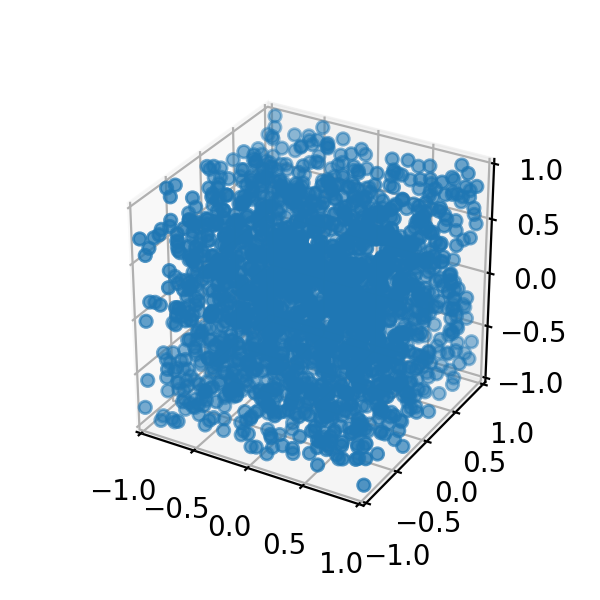

<IPython.core.display.Javascript object>


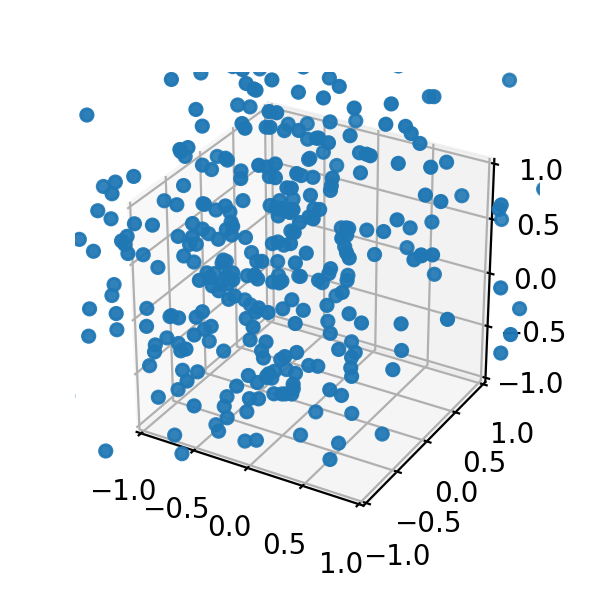

In [29]:
# Visualization
from mpl_toolkits.mplot3d import Axes3D
for pt_cl_item in pt_cl_list:
    visualize(pt_cl_item)

In [ ]:
visualize(tr_pts)

In [ ]:
visualize(perturbed_points)